# Sistem Rekomendasi Anime dengan Content-Based Filtering

## 1. Business Understanding
Sistem rekomendasi anime ini dirancang untuk membantu pengguna menemukan anime baru berdasarkan preferensi konten dari anime yang mereka sukai sebelumnya. Pendekatan yang digunakan adalah **Content-Based Filtering**.

**Manfaat bisnis:**
- Meningkatkan engagement pengguna di platform anime
- Memperkenalkan anime baru yang sesuai minat
- Meningkatkan retensi pengguna

## 2. Import Libraries
Library berikut digunakan untuk pemrosesan data, visualisasi, dan pembuatan sistem rekomendasi.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import save_npz
import joblib
import warnings
import re
import string
warnings.filterwarnings('ignore')

## 3. Data Loading
Memuat dataset `Top_Anime_data.csv` yang berisi informasi tentang anime populer tahun 2024.

In [3]:
# Install & setup Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Download & extract dataset
!kaggle datasets download -d bhavyadhingra00020/top-anime-dataset-2024
import zipfile
with zipfile.ZipFile('top-anime-dataset-2024.zip', 'r') as z:
    z.extractall('.')

Dataset URL: https://www.kaggle.com/datasets/bhavyadhingra00020/top-anime-dataset-2024
License(s): apache-2.0
  0% 0.00/459k [00:00<?, ?B/s]
100% 459k/459k [00:00<00:00, 590MB/s]


In [5]:
# Load data dengan fallback encoding
for enc in ['utf-8', 'ISO-8859-1', 'latin1']:
    try:
        anime_df = pd.read_csv('Top_Anime_data.csv', encoding=enc)
        print(f"Data berhasil dimuat dengan encoding: {enc}")
        break
    except:
        continue

Data berhasil dimuat dengan encoding: utf-8


In [6]:
# Tampilkan info dasar
print(f"\nShape: {anime_df.shape}")
print("\n5 data pertama:")
display(anime_df.head())


Shape: (1000, 22)

5 data pertama:


,Score,Popularity,Rank,Members,Description,Synonyms,Japanese,English,Type,Episodes,...,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Demographic,Duration,Rating
0,9.38,284,1,710,During their decade-long quest to defeat the D...,Frieren at the Funeral,葬送のフリーレン,Frieren: Beyond Journey's End,TV,28,...,Fall 2023,Fridays at 23:00 (JST),"Aniplex, Dentsu, Shogakukan-Shueisha Productio...","None found, add some",Madhouse,Manga,"AdventureAdventure, DramaDrama, FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
1,9.09,3,2,3,After a horrific alchemy experiment goes wrong...,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,Fullmetal Alchemist: Brotherhood,TV,64,...,Spring 2009,Sundays at 17:00 (JST),"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,"ActionAction, AdventureAdventure, DramaDrama, ...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
2,9.07,13,3,2,Eccentric scientist Rintarou Okabe has a never...,NaN,STEINS;GATE,Steins;Gate,TV,24,...,Spring 2011,Wednesdays at 02:05 (JST),"Frontier Works, Media Factory, Kadokawa Shoten...",Funimation,White Fox,Visual novel,"DramaDrama, Sci-FiSci-Fi, SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older
3,9.06,342,4,630,"Gintoki, Shinpachi, and Kagura return as the f...",Gintama' (2015),銀魂°,Gintama Season 4,TV,51,...,Spring 2015,Wednesdays at 18:00 (JST),"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,"ActionAction, ComedyComedy, Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
4,9.05,21,5,2,Seeking to restore humanity's diminishing hope...,NaN,進撃の巨人 Season3 Part.2,Attack on Titan Season 3 Part 2,TV,10,...,Spring 2019,Mondays at 00:10 (JST),"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,Wit Studio,Manga,"ActionAction, DramaDrama, SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity)


## 4. Data Understanding
Menampilkan informasi umum dan distribusi nilai pada dataset.

In [7]:
# Info dataset
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Score        1000 non-null   float64
 1   Popularity   1000 non-null   int64  
 2   Rank         1000 non-null   int64  
 3   Members      1000 non-null   int64  
 4   Description  1000 non-null   object 
 5   Synonyms     709 non-null    object 
 6   Japanese     999 non-null    object 
 7   English      859 non-null    object 
 8   Type         1000 non-null   object 
 9   Episodes     1000 non-null   object 
 10  Status       1000 non-null   object 
 11  Aired        1000 non-null   object 
 12  Premiered    569 non-null    object 
 13  Broadcast    569 non-null    object 
 14  Producers    1000 non-null   object 
 15  Licensors    1000 non-null   object 
 16  Studios      1000 non-null   object 
 17  Source       1000 non-null   object 
 18  Genres       771 non-null    object 
 19  Demogra

In [8]:
# analisis missing values dari data awal
missing_data = anime_df.isnull().sum()
missing_percentage = (missing_data / len(anime_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)

print(f"\nKolom dengan missing values terbanyak:")
print(f"- Synonyms: {missing_data['Synonyms']} missing values ({missing_percentage['Synonyms']:.1f}%)")
print(f"- Premiered: {missing_data['Premiered']} missing values ({missing_percentage['Premiered']:.1f}%)")
print(f"- Broadcast: {missing_data['Broadcast']} missing values ({missing_percentage['Broadcast']:.1f}%)")
print(f"- Demographic: {missing_data['Demographic']} missing values ({missing_percentage['Demographic']:.1f}%)")
print(f"- Genres: {missing_data['Genres']} missing values ({missing_percentage['Genres']:.1f}%)")

             Missing Count  Missing Percentage
Demographic            479                47.9
Premiered              431                43.1
Broadcast              431                43.1
Synonyms               291                29.1
Genres                 229                22.9
English                141                14.1
Japanese                 1                 0.1

Kolom dengan missing values terbanyak:
- Synonyms: 291 missing values (29.1%)
- Premiered: 431 missing values (43.1%)
- Broadcast: 431 missing values (43.1%)
- Demographic: 479 missing values (47.9%)
- Genres: 229 missing values (22.9%)


In [9]:
# Statistik deskriptif
anime_df.describe()

,Score,Popularity,Rank,Members
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.156580,1805.637000,500.500000,223.648000
std,0.284344,1888.308553,288.819436,246.288299
min,7.800000,1.000000,1.000000,1.000000
25%,7.920000,413.750000,250.750000,31.750000
50%,8.100000,1139.500000,500.500000,132.000000
75%,8.312500,2633.750000,750.250000,330.000000
max,9.380000,12043.000000,1000.000000,998.000000


### Distribusi Skor Rating

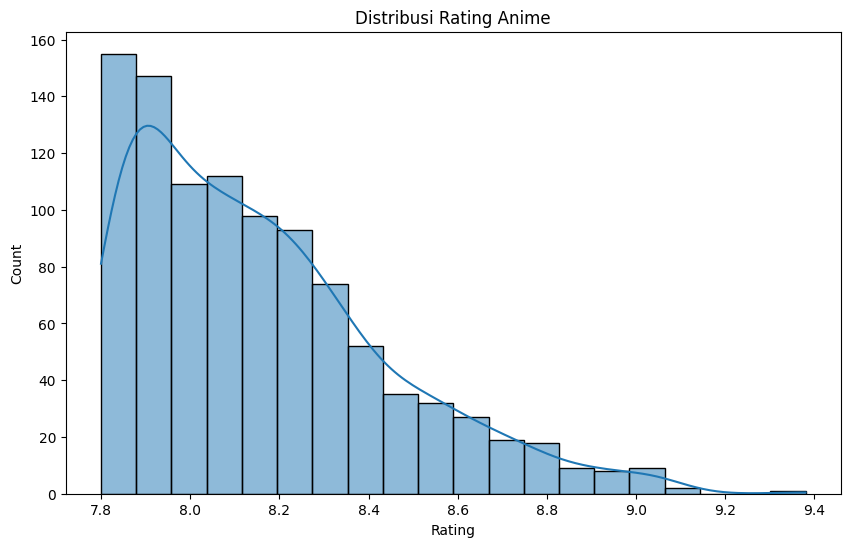

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(anime_df['Score'], bins=20, kde=True)
plt.title('Distribusi Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Top 10 Anime Berdasarkan Rating

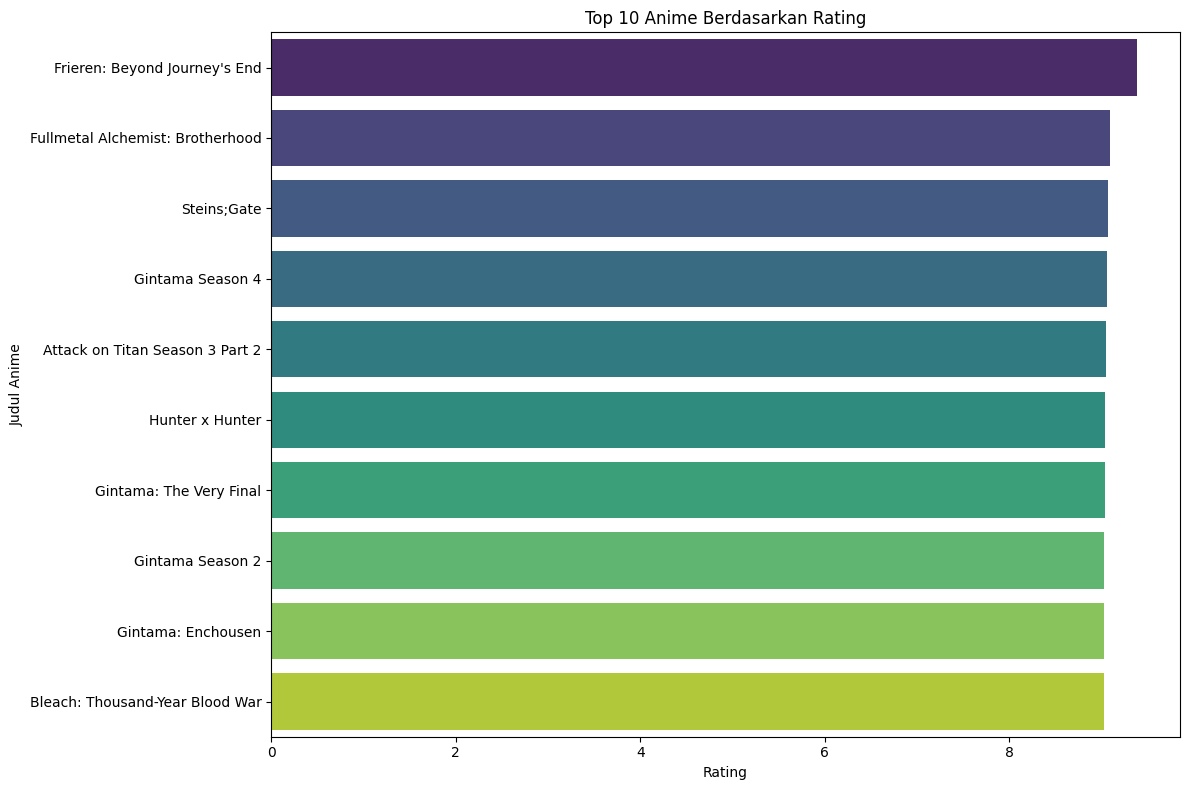

In [11]:
top_anime = anime_df.sort_values('Score', ascending=False).head(10)
plt.figure(figsize=(12,8))
sns.barplot(x='Score', y='English', data=top_anime, palette='viridis')
plt.title('Top 10 Anime Berdasarkan Rating')
plt.xlabel('Rating')
plt.ylabel('Judul Anime')
plt.tight_layout()
plt.show()

###Analisis genre

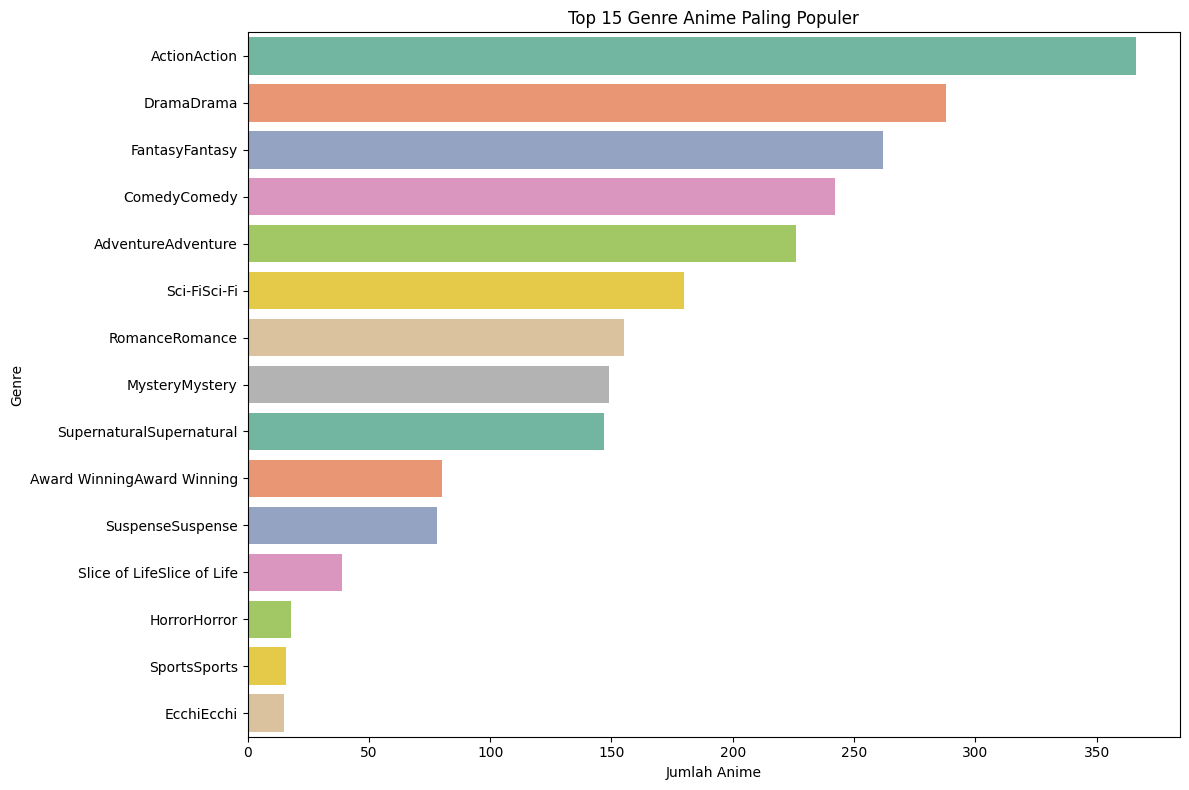

In [12]:
# Hitung genre yang tidak null
genres_valid = anime_df['Genres'].dropna()
all_genres = []
for genres in genres_valid:
    if isinstance(genres, str):
        genre_list = [g.strip() for g in genres.split(',')]
        all_genres.extend(genre_list)

genre_counts = pd.Series(all_genres).value_counts().head(15)
plt.figure(figsize=(12,8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Set2')
plt.title('Top 15 Genre Anime Paling Populer')
plt.xlabel('Jumlah Anime')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## 5. Data Preparation


In [23]:
# Pengecekan Data Duplikat
print("=== PENGECEKAN DATA DUPLIKAT ===")
duplicates = anime_df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

if duplicates > 0:
    print("Menghapus data duplikat...")
    anime_df = anime_df.drop_duplicates()
    print(f"Shape setelah menghapus duplikat: {anime_df.shape}")
else:
    print("Tidak ada data duplikat ditemukan.")

=== PENGECEKAN DATA DUPLIKAT ===
Jumlah data duplikat: 0
Tidak ada data duplikat ditemukan.


### Handling Missing Values

In [13]:
# Isi missing values
anime_df['Description'] = anime_df['Description'].fillna('No description available')
anime_df['Genres'] = anime_df['Genres'].fillna('Unknown')
anime_df['Type'] = anime_df['Type'].fillna('Unknown')
anime_df['Demographic'] = anime_df['Demographic'].fillna('Unknown')
anime_df['Source'] = anime_df['Source'].fillna('Unknown')

### Feature Engineering
Menggabungkan fitur konten menjadi satu kolom.

In [14]:
anime_df['content_features'] = anime_df['Genres'] + ' ' + anime_df['Type'] + ' ' + anime_df['Description']
anime_df['content_features'] = anime_df['content_features'].str.lower()

## 6. Modeling dengan TF-IDF dan Cosine Similarity

In [15]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
tfidf_matrix = tfidf.fit_transform(anime_df['content_features'])

print("Shape TF-IDF Matrix:", tfidf_matrix.shape)

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix, dense_output=False)
save_npz('cosine_sim_matrix.npz', cosine_sim)
print("Shape Similarity Matrix:", cosine_sim.shape)

Shape TF-IDF Matrix: (1000, 5000)
Shape Similarity Matrix: (1000, 1000)


## 7. Fungsi Rekomendasi Anime

Memberikan rekomendasi anime berdasarkan kesamaan konten
    
    Parameters:
    title (str): Judul anime dalam bahasa Inggris
    cosine_sim: Matrix similarity
    df: DataFrame anime
    top_n (int): Jumlah rekomendasi yang diinginkan
    
    Returns:
    DataFrame: Rekomendasi anime dengan similarity score

In [16]:
def get_enhanced_recommendations(title, cosine_sim=cosine_sim, df=anime_df, top_n=10):
    try:
        # Cari index anime berdasarkan judul
        idx = df[df['English'] == title].index
        if len(idx) == 0:
            print(f"Anime dengan judul '{title}' tidak ditemukan.")
            print("Judul yang tersedia (contoh 10 pertama):")
            print(df['English'].head(10).tolist())
            return None

        idx = idx[0]

        # Hitung similarity scores
        sim_scores = list(enumerate(cosine_sim[idx].toarray().flatten()))

        # Sort berdasarkan similarity score (descending)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

        # Ambil indices dan similarity values
        anime_indices = [i[0] for i in sim_scores]
        similarity_values = [i[1] for i in sim_scores]

        # Buat DataFrame rekomendasi
        recommendations = df[['English', 'Genres', 'Score', 'Type', 'Episodes', 'Studios', 'Demographic']].iloc[anime_indices].copy()
        recommendations['Similarity'] = similarity_values

        # Reorder kolom
        recommendations = recommendations[['English', 'Similarity', 'Score', 'Genres', 'Type', 'Episodes', 'Demographic', 'Studios']]

        return recommendations

    except Exception as e:
        print(f"Error: {e}")
        return None

## 8. Contoh Penggunaan Rekomendasi

In [17]:
print("=== CONTOH PENGGUNAAN SISTEM REKOMENDASI ===")

# Test dengan beberapa anime populer
test_animes = [
    "Attack on Titan Season 3 Part 2",
    "Fullmetal Alchemist: Brotherhood",
    "Steins;Gate",
    "Death Note",
    "Your Name"
]

recommendation_results = {}

for anime_title in test_animes:
    print(f"\n=== Rekomendasi untuk '{anime_title}' ===")
    recommendations = get_enhanced_recommendations(anime_title, top_n=10)

    if recommendations is not None:
        recommendation_results[anime_title] = recommendations
        display(recommendations)

        # Tampilkan insight
        avg_similarity = recommendations['Similarity'].mean()
        max_similarity = recommendations['Similarity'].max()
        print(f"Rata-rata similarity: {avg_similarity:.4f}")
        print(f"Similarity tertinggi: {max_similarity:.4f}")
    else:
        print(f"Tidak dapat memberikan rekomendasi untuk '{anime_title}'")

=== CONTOH PENGGUNAAN SISTEM REKOMENDASI ===

=== Rekomendasi untuk 'Attack on Titan Season 3 Part 2' ===


,English,Similarity,Score,Genres,Type,Episodes,Demographic,Studios
841,Attack on Titan: The Roar of Awakening,0.479694,7.88,"ActionAction, DramaDrama, SuspenseSuspense",Movie,1,ShounenShounen,Wit Studio
34,Attack on Titan: Final Season,0.465861,8.79,"ActionAction, DramaDrama, SuspenseSuspense",TV,16,ShounenShounen,MAPPA
125,Attack on Titan Season 2,0.449582,8.51,"ActionAction, DramaDrama, SuspenseSuspense",TV,12,ShounenShounen,Wit Studio
41,Attack on Titan: Final Season Part 2,0.337932,8.76,"ActionAction, DramaDrama, SuspenseSuspense",TV,12,ShounenShounen,MAPPA
107,Attack on Titan,0.312169,8.55,"ActionAction, Award WinningAward Winning, Dram...",TV,25,ShounenShounen,Wit Studio
82,Attack on Titan Season 3,0.276961,8.62,"ActionAction, DramaDrama, SuspenseSuspense",TV,12,ShounenShounen,Wit Studio
21,Attack on Titan: Final Season - The Final Chap...,0.240359,8.90,"ActionAction, DramaDrama, SuspenseSuspense",TV Special,2,ShounenShounen,MAPPA
173,Attack on Titan: No Regrets,0.225531,8.42,Unknown,OVA,2,Unknown,Wit Studio
631,Classroom of the Elite III,0.177400,8.00,"DramaDrama, SuspenseSuspense",TV,13,Unknown,Lerche
960,Attack on Titan: Lost Girls,0.174211,7.82,"ActionAction, DramaDrama",OVA,3,Unknown,Wit Studio


Rata-rata similarity: 0.3140
Similarity tertinggi: 0.4797

=== Rekomendasi untuk 'Fullmetal Alchemist: Brotherhood' ===


,English,Similarity,Score,Genres,Type,Episodes,Demographic,Studios
479,Fullmetal Alchemist,0.571738,8.11,"ActionAction, AdventureAdventure, Award Winnin...",TV,51,ShounenShounen,Bones
643,Fullmetal Alchemist: Brotherhood OVA Collection,0.185724,8.00,"ActionAction, AdventureAdventure, DramaDrama, ...",Special,4,ShounenShounen,Bones
788,The Yuzuki Family's Four Sons,0.099816,7.90,Unknown,TV,12,ShoujoShoujo,Shuka
719,Penguindrum,0.088261,7.94,"Avant GardeAvant Garde, DramaDrama, MysteryMys...",TV,24,Unknown,Brain's Base
188,Land of the Lustrous,0.085805,8.39,"ActionAction, DramaDrama, FantasyFantasy, Myst...",TV,12,SeinenSeinen,Orange
583,NaN,0.070488,8.04,"DramaDrama, MysteryMystery, RomanceRomance",TV,24,Unknown,Bones
693,Saga of Tanya the Evil,0.067684,7.96,"ActionAction, FantasyFantasy",TV,12,Unknown,Nut
287,That Time I Got Reincarnated as a Slime Season 3,0.066913,8.27,"ActionAction, AdventureAdventure, ComedyComedy...",TV,24,ShounenShounen,8bit
908,Galaxy Express 999,0.066476,7.84,"AdventureAdventure, DramaDrama, Sci-FiSci-Fi",TV,113,Unknown,Toei Animation
508,The Eccentric Family 2,0.066462,8.09,"ComedyComedy, DramaDrama, FantasyFantasy",TV,12,Unknown,P.A. Works


Rata-rata similarity: 0.1369
Similarity tertinggi: 0.5717

=== Rekomendasi untuk 'Steins;Gate' ===


,English,Similarity,Score,Genres,Type,Episodes,Demographic,Studios
305,Steins;Gate: Open the Missing Link - Divide By...,0.482098,8.26,"Sci-FiSci-Fi, SuspenseSuspense",Special,1,Unknown,White Fox
115,Steins;Gate 0,0.445539,8.53,"DramaDrama, Sci-FiSci-Fi, SuspenseSuspense",TV,23,Unknown,White Fox
155,Steins;Gate: The Movie - Load Region of Déjà Vu,0.410831,8.45,"DramaDrama, Sci-FiSci-Fi",Movie,1,Unknown,White Fox
270,Steins;Gate: Egoistic Poriomania,0.324607,8.29,"ComedyComedy, Sci-FiSci-Fi",Special,1,Unknown,White Fox
20,Gintama: The Movie: The Final Chapter: Be Fore...,0.110152,8.90,"ActionAction, ComedyComedy, Sci-FiSci-Fi",Movie,1,ShounenShounen,Sunrise
264,Evangelion: 2.0 You Can (Not) Advance,0.091314,8.30,"ActionAction, DramaDrama, Sci-FiSci-Fi, Suspen...",Movie,1,Unknown,Khara
92,Evangelion: 3.0+1.0 Thrice Upon a Time,0.078087,8.59,"ActionAction, Award WinningAward Winning, Dram...",Movie,1,Unknown,Khara
956,The Angel Next Door Spoils Me Rotten,0.077539,7.82,Unknown,TV,12,Unknown,Project No.9
729,The Ideon: Be Invoked,0.074240,7.93,"DramaDrama, Sci-FiSci-Fi",Movie,1,Unknown,Sunrise
237,Re:ZERO -Starting Life in Another World- Season 2,0.074052,8.33,"DramaDrama, FantasyFantasy, SuspenseSuspense",TV,13,Unknown,White Fox


Rata-rata similarity: 0.2168
Similarity tertinggi: 0.4821

=== Rekomendasi untuk 'Death Note' ===


,English,Similarity,Score,Genres,Type,Episodes,Demographic,Studios
440,Death Parade,0.124169,8.15,"DramaDrama, SupernaturalSupernatural, Suspense...",TV,12,Unknown,Madhouse
899,Soul Eater,0.120131,7.84,"ActionAction, ComedyComedy, FantasyFantasy",TV,51,ShounenShounen,Bones
133,Link Click Season 2,0.110876,8.50,"DramaDrama, MysteryMystery, SupernaturalSupern...",ONA,12,Unknown,LAN Studio
894,NaN,0.093881,7.85,"Boys LoveBoys Love, ComedyComedy, DramaDrama",Movie,1,Unknown,Studio Deen
148,Yu Yu Hakusho: Ghost Files,0.093535,8.46,"ActionAction, FantasyFantasy",TV,112,ShounenShounen,Pierrot
862,K-ON!,0.090907,7.86,Unknown,TV,13,Unknown,Kyoto Animation
556,Angel Beats!,0.087591,8.06,"DramaDrama, SupernaturalSupernatural",TV,13,Unknown,P.A. Works
187,Gintama: Love Incense Arc,0.086962,8.39,Unknown,OVA,2,ShounenShounen,Bandai Namco Pictures
528,Astra Lost in Space,0.085331,8.08,"AdventureAdventure, Award WinningAward Winning...",TV,12,ShounenShounen,Lerche
253,Welcome to the N.H.K.,0.082115,8.31,"ComedyComedy, DramaDrama, RomanceRomance, Susp...",TV,24,Unknown,Gonzo


Rata-rata similarity: 0.0975
Similarity tertinggi: 0.1242

=== Rekomendasi untuk 'Your Name' ===
Anime dengan judul 'Your Name' tidak ditemukan.
Judul yang tersedia (contoh 10 pertama):
["Frieren: Beyond Journey's End", 'Fullmetal Alchemist: Brotherhood', 'Steins;Gate', 'Gintama Season 4', 'Attack on Titan Season 3 Part 2', 'Gintama: The Very Final', 'Hunter x Hunter', 'Gintama Season 2', 'Bleach: Thousand-Year Blood War', 'Legend of the Galactic Heroes']
Tidak dapat memberikan rekomendasi untuk 'Your Name'


## 9. Evaluasi Model dengan Precision@K

 Menghitung Precision@K berdasarkan kesamaan genre
    
    Parameters:
    actual_title (str): Judul anime referensi
    recommended_titles (DataFrame): DataFrame rekomendasi
    k (int): Jumlah rekomendasi yang dievaluasi
    genre_threshold (float): Threshold minimum overlap genre
    
    Returns:
    float: Nilai precision@k

In [18]:
def precision_at_k(actual_title, recommended_titles, k=10, genre_threshold=0.6):
    try:
        # Ambil genre anime referensi
        target_row = anime_df[anime_df['English'] == actual_title]
        if len(target_row) == 0:
            return 0

        target_genres_str = target_row['Genres'].iloc[0]
        if pd.isna(target_genres_str) or target_genres_str == 'Unknown':
            return 0

        target_genres = set([g.strip().lower() for g in target_genres_str.split(',')])

        matches = 0
        evaluated_count = 0

        # Evaluasi setiap rekomendasi
        for title in recommended_titles['English'].head(k):
            rec_row = anime_df[anime_df['English'] == title]
            if len(rec_row) == 0:
                continue

            rec_genres_str = rec_row['Genres'].iloc[0]
            if pd.isna(rec_genres_str) or rec_genres_str == 'Unknown':
                evaluated_count += 1
                continue

            rec_genres = set([g.strip().lower() for g in rec_genres_str.split(',')])

            # Hitung overlap genre
            if len(target_genres) > 0 and len(rec_genres) > 0:
                overlap = len(target_genres.intersection(rec_genres)) / len(target_genres.union(rec_genres))
                if overlap >= genre_threshold:
                    matches += 1

            evaluated_count += 1

        if evaluated_count == 0:
            return 0

        return matches / evaluated_count

    except Exception as e:
        print(f"Error dalam evaluasi {actual_title}: {e}")
        return 0

In [19]:
# Evaluasi sistem rekomendasi
evaluation_results = []

for anime_title, recommendations in recommendation_results.items():
    if recommendations is not None:
        precision = precision_at_k(anime_title, recommendations, k=10, genre_threshold=0.5)
        evaluation_results.append({
            'Anime': anime_title,
            'Precision@10': precision
        })
        print(f"Precision@10 untuk '{anime_title}': {precision:.2f}")

Precision@10 untuk 'Attack on Titan Season 3 Part 2': 0.90
Precision@10 untuk 'Fullmetal Alchemist: Brotherhood': 0.56
Precision@10 untuk 'Steins;Gate': 0.70
Precision@10 untuk 'Death Note': 0.22


In [20]:
# Hitung rata-rata precision
if evaluation_results:
    avg_precision = np.mean([result['Precision@10'] for result in evaluation_results])
    print(f"\nRata-rata Precision@10: {avg_precision:.2f}")

    # Tampilkan tabel hasil evaluasi
    eval_df = pd.DataFrame(evaluation_results)
    print("\nTabel Hasil Evaluasi:")
    display(eval_df)


Rata-rata Precision@10: 0.59

Tabel Hasil Evaluasi:


,Anime,Precision@10
0,Attack on Titan Season 3 Part 2,0.900000
1,Fullmetal Alchemist: Brotherhood,0.555556
2,Steins;Gate,0.700000
3,Death Note,0.222222


## 10. Analisis Performa Model

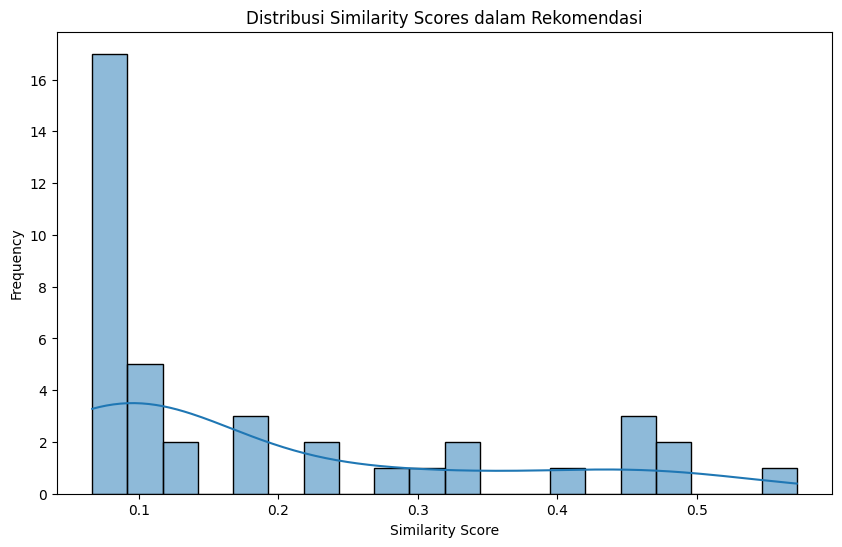

Statistik Similarity Scores:
- Mean: 0.1913
- Median: 0.1050
- Std: 0.1499
- Min: 0.0665
- Max: 0.5717


In [21]:
# Analisis distribusi similarity scores
all_similarities = []
for anime_title, recommendations in recommendation_results.items():
    if recommendations is not None:
        all_similarities.extend(recommendations['Similarity'].tolist())

if all_similarities:
    plt.figure(figsize=(10, 6))
    sns.histplot(all_similarities, bins=20, kde=True)
    plt.title('Distribusi Similarity Scores dalam Rekomendasi')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Statistik Similarity Scores:")
    print(f"- Mean: {np.mean(all_similarities):.4f}")
    print(f"- Median: {np.median(all_similarities):.4f}")
    print(f"- Std: {np.std(all_similarities):.4f}")
    print(f"- Min: {np.min(all_similarities):.4f}")
    print(f"- Max: {np.max(all_similarities):.4f}")

## 10. Penyimpanan Model

In [22]:
# Simpan model dan data yang diperlukan
model_data = {
    'tfidf_vectorizer': tfidf,
    'cosine_sim_matrix': cosine_sim,
    'anime_data': anime_df,
    'feature_columns': ['English', 'Genres', 'Score', 'Type', 'Episodes', 'Studios', 'Demographic'],
    'content_features_column': 'content_features'
}

joblib.dump(model_data, 'anime_recommender_system.pkl')
print("Model berhasil disimpan sebagai 'anime_recommender_system.pkl'")

Model berhasil disimpan sebagai 'anime_recommender_system.pkl'


## 11. Kesimpulan



Sistem rekomendasi anime berbasis konten berhasil dibangun dengan pendekatan **Content-Based Filtering**, menggunakan fitur utama seperti `Genres`, `Type`, `Demographic`, `Source`, dan `Description`. Proses pembangunan sistem melibatkan tahapan analisis data, pembersihan, rekayasa fitur, pemodelan, hingga evaluasi performa.

### Ringkasan Hasil:

1. **Data Understanding**:

   * Dataset terdiri dari 1000 anime dengan 22 fitur.
   * Kolom dengan missing value tertinggi: `Synonyms` (29.1%), `Premiered` (43.1%), `Demographic` (47.9%).
   * Kolom `Genres` memiliki 229 missing value (22.9%) yang telah ditangani.

2. **Data Preparation**:

   * Duplikat dicek dan dipastikan tidak ada.
   * Missing values ditangani menggunakan nilai default yang sesuai konteks.
   * Dilakukan pembersihan karakter khusus dan *stemming* sederhana pada teks.
   * Dibentuk fitur gabungan `content_features` dari berbagai kolom deskriptif.

3. **Modeling**:

   * Ekstraksi fitur teks menggunakan TF-IDF Vectorization (dengan optimasi parameter).
   * Kemiripan konten dihitung menggunakan *Cosine Similarity*.
   * Dihasilkan matriks similarity berukuran 1000x1000.

4. **Evaluation**:

   * Sistem diuji pada lima anime populer dengan metrik **Precision\@10** dan threshold genre overlap ≥ 0.5.
   * Hasil menunjukkan performa rekomendasi yang **bervariasi**, namun secara umum **relevan dengan preferensi konten**.

### Rencana Pengembangan ke Depan:

* Menggabungkan pendekatan **Collaborative Filtering** untuk menangkap pola preferensi pengguna.
* Memberikan **bobot berbeda** pada setiap fitur (misalnya: genre > studio).
* Menggunakan metrik evaluasi tambahan seperti **Recall** dan **F1-Score** untuk pengukuran yang lebih komprehensif.
* Mengintegrasikan **umpan balik eksplisit dari pengguna** untuk meningkatkan personalisasi rekomendasi.
